#cnn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import to_categorical
import glob
import os
from sklearn.model_selection import train_test_split

# 주파수 특성 추출 함수 (이전과 동일)
max_length = 15

def extract_features(audio_file, max_length):
    y, sr = librosa.load(audio_file, sr=None)
    if len(y) < max_length:
        y = np.pad(y, (0, max_length - len(y)), 'constant')
    elif len(y) > max_length:
        y = y[:max_length]
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features = np.concatenate((mfccs.flatten(), chroma.flatten(), spectral_contrast.flatten()))
    return features

def get_files_from_dir(path, file_format):
    # 주어진 경로와 그 하위 경로에서 특정 형식의 파일들을 찾습니다.
    return glob.glob(os.path.join(path, f'**/*.{file_format}'), recursive=True)



In [ ]:
# AI 음성파일들
ai_subfolders = ['mh', 'sm', 'sy']
ai_audio_files = []
for folder in ai_subfolders:
    ai_audio_files.extend(get_files_from_dir(f'/content/drive/MyDrive/PBL/ai_voice/ai_padding/{folder}', 'mp3'))

# 사람 음성파일들
human_subfolders = ['sy', 'hs', 'cy']
human_audio_files = []
for folder in human_subfolders:
    human_audio_files.extend(get_files_from_dir(f'/content/drive/MyDrive/PBL/ai_voice/human_padding/{folder}', 'mp3'))

ai_features = [extract_features(audio_file,max_length) for audio_file in ai_audio_files]
human_features = [extract_features(audio_file,max_length) for audio_file in human_audio_files]

ai_labels = np.zeros(len(ai_features))
human_labels = np.ones(len(human_features))

X_train_test= np.vstack(ai_features + human_features)
y_train_test= np.concatenate((ai_labels, human_labels))

print("Shape of X_train_test:", X_train_test.shape)
print("Shape of y_train_test:", y_train_test.shape)

# 학습 데이터와 테스트 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(X_train_test,y_train_test,test_size=0.2)


ValueError: ignored

In [ ]:
#슬라이딩

import librosa
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import glob
import os

# 주파수 특성 추출 함수 (슬라이딩 윈도우 사용)
max_length = 5  # 각 슬라이딩 윈도우의 길이 (초)
window_hop = 0.5   # 윈도우를 이동시키는 간격 (초)

def get_files_from_dir(path, file_format):
    # 주어진 경로와 그 하위 경로에서 특정 형식의 파일들을 찾습니다.
    return glob.glob(os.path.join(path, f'**/*.{file_format}'), recursive=True)

def extract_features(audio_files):
    features = []
    for audio_file in audio_files:
        try:
            y, sr = librosa.load(audio_file)
            sr_per_window = int(sr * max_length)
            sr_hop = int(sr * window_hop)

            for i in range(0, len(y) - sr_per_window + 1, sr_hop):
                window = y[i:i+sr_per_window]
                mfccs = librosa.feature.mfcc(y=window, sr=sr)
                chroma_stft = librosa.feature.chroma_stft(y=window,sr=sr)
                spectral_contrast=librosa.feature.spectral_contrast(y=window,sr=sr)

                window_features=np.concatenate((mfccs.mean(axis=1),chroma_stft.mean(axis=1),spectral_contrast.mean(axis=1)))

                features.append(window_features)

        except Exception as e:
            print(f"Error processing {audio_file}: {str(e)}")

    return np.array(features)

# AI 음성파일들
ai_subfolders = ['mh', 'sm', 'sy']
ai_audio_files = []
for folder in ai_subfolders:
    ai_audio_files.extend(get_files_from_dir(f'/content/drive/MyDrive/PBL/ai_voice/ai_padding/{folder}', 'mp3'))

# 사람 음성파일들
human_subfolders = ['sy', 'hs', 'cy']
human_audio_files = []
for folder in human_subfolders:
    human_audio_files.extend(get_files_from_dir(f'/content/drive/MyDrive/PBL/ai_voice/human_padding/{folder}', 'mp3'))

ai_features = [extract_features(audio_file) for audio_file in ai_audio_files]
human_features = [extract_features(audio_file) for audio_file in human_audio_files]

#ai_audio_files=get_files_from_dir('/content/drive/MyDrive/PBL/ai_voice/ai2_padding_cut/', 'mp3')
#human_audio_files=get_files_from_dir('/content/drive/MyDrive/PBL/ai_voice/human2_padding_cut/', 'mp3')

# AI 음성 특징 추출 및 레이블 생성
ai_features_train_test_fullset=extract_features(ai_audio_files)
ai_labels_train_test_fullset=np.zeros(len(ai_features_train_test_fullset))

# 사람 음성 특징 추출 및 레이블 생성
human_features_train_test_fullset=extract_features(human_audio_files)
human_labels_train_test_fullset=np.ones(len(human_features_train_test_fullset))

X_train,X_val,y_train,y_val=train_test_split(np.concatenate([ai_features_train_test_fullset,human_features_train_test_fullset]),
                                             np.concatenate([ai_labels_train_test_fullset,human_labels_train_test_fullset]),test_size=0.2)

# 원-핫 인코딩을 위해 y 값을 변환
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

In [ ]:
import librosa
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import glob
import os

# 주파수 특성 추출 함수 (슬라이딩 윈도우 사용)
max_length = 5  # 각 슬라이딩 윈도우의 길이 (초)
window_hop = 0.5   # 윈도우를 이동시키는 간격 (초)

def get_files_from_dir(path, file_format):
    # 주어진 경로와 그 하위 경로에서 특정 형식의 파일들을 찾습니다.
    return glob.glob(os.path.join(path, f'**/*.{file_format}'), recursive=True)

def extract_features(audio_files):
    features = []
    for audio_file in audio_files:
        try:
            y, sr = librosa.load(audio_file)
            mfccs = librosa.feature.mfcc(y=y, sr=sr)
            chroma_stft = librosa.feature.chroma_stft(y=y,sr=sr)
            spectral_contrast=librosa.feature.spectral_contrast(y=y,sr=sr)

            file_features=np.concatenate((mfccs.mean(axis=1),chroma_stft.mean(axis=1),spectral_contrast.mean(axis=1)))

            features.append(file_features)

        except Exception as e:
            print(f"Error processing {audio_file}: {str(e)}")

    return np.array(features)


# AI 음성파일들
ai_subfolders = ['mh', 'sm', 'sy']
ai_audio_files = []
for folder in ai_subfolders:
    ai_audio_files.extend(get_files_from_dir(f'/content/drive/MyDrive/PBL/ai_voice/ai_padding/{folder}', 'mp3'))

# 사람 음성파일들
human_subfolders = ['sy', 'hs', 'cy']
human_audio_files = []
for folder in human_subfolders:
    human_audio_files.extend(get_files_from_dir(f'/content/drive/MyDrive/PBL/ai_voice/human_padding/{folder}', 'mp3'))

ai_features = [extract_features(audio_file) for audio_file in ai_audio_files]
human_features = [extract_features(audio_file) for audio_file in human_audio_files]

# AI 음성 특징 추출 및 레이블 생성
#ai_features_train_test_fullset=extract_features(ai_audio_files)
#ai_labels_train_test_fullset=np.zeros(len(ai_features_train_test_fullset))

# 사람 음성 특징 추출 및 레이블 생성
human_features_train_test_fullset=extract_features(human_audio_files)
human_labels_train_test_fullset=np.ones(len(human_features_train_test_fullset))

X_train,X_val,y_train,y_val=train_test_split(np.concatenate([ai_features_train_test_fullset,human_features_train_test_fullset]),
                                             np.concatenate([ai_labels_train_test_fullset,human_labels_train_test_fullset]),test_size=0.2)

# 원-핫 인코딩을 위해 y 값을 변환
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

In [ ]:
# 모델ver1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Dropout,Flatten,Dense,BatchNormalization

model = Sequential()

# y_train은 원-핫 인코딩된 레이블 데이터입니다.
number_of_classes = y_train.shape[1]


# 첫 번째 합성곱 계층
model.add(Conv1D(64,kernel_size=3,
activation='relu',
input_shape=(X_train.shape[1],
1)))
model.add(BatchNormalization())
model.add(Conv1D(64,kernel_size=3,
activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

# 두 번째 합성곱 계층
model.add(Conv1D(128,kernel_size=3,
activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128,kernel_size=3,
activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(.5))

# 완전 연결 계층으로 전환하기 위해 Flatten layer 추가
model.add(Flatten())

# 첫 번째 Dense Layer (완전 연결 계층)
model.add(Dense(256, activation='relu'))
# Batch Normalization layer 추가
model.add(BatchNormalization())
# Dropout 추가
model.add(Dropout(.5))
# 두 번째 Dense Layer (완전 연결 계층)
model.add(Dense(number_of_classes, activation='softmax'))


In [ ]:
#모델ver2

from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Dropout,Flatten,Dense,BatchNormalization

model = Sequential()

# y_train은 원-핫 인코딩된 레이블 데이터입니다.
number_of_classes = y_train.shape[1]

# 첫 번째 합성곱 계층
model.add(Conv1D(64,kernel_size=3,
activation='relu',
input_shape=(X_train.shape[1],
1),
kernel_regularizer=l2(0.01))) # L2 regularization 추가
model.add(BatchNormalization())
model.add(Conv1D(64,kernel_size=3,
activation='relu',
kernel_regularizer=l2(0.01))) # L2 regularization 추가
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

# 두 번째 합성곱 계층
model.add(Conv1D(128,kernel_size=3,
activation='relu',
kernel_regularizer=l2(0.01))) # L2 regularization 추가
model.add(BatchNormalization())
model.add(Conv1D(128,kernel_size=3,
activation='relu',
kernel_regularizer=l2(0.01))) # L2 regularization 추가
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(.5))

# 완전 연결 계층으로 전환하기 위해 Flatten layer 추가
model.add(Flatten())

# 첫 번째 Dense Layer (완전 연결 계층)
model.add(Dense(256, activation='relu'))
# Batch Normalization layer 추가
model.add(BatchNormalization())
# Dropout 추가
model.add(Dropout(.5))
# 두 번째 Dense Layer (완전 연결 계층)
model.add(Dense(number_of_classes, activation='softmax'))

In [ ]:
# 모델ver3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Dropout,Flatten,Dense,BatchNormalization

model = Sequential()

# 첫 번째 합성곱 계층
model.add(Conv1D(64,kernel_size=3,
activation='relu',
input_shape=(X_train.shape[1],
1),
kernel_regularizer=l2(0.02))) # L2 regularization 값 변경
model.add(BatchNormalization())
model.add(Conv1D(64,kernel_size=3,
activation='relu',
kernel_regularizer=l2(0.02))) # L2 regularization 값 변경
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3)) # Dropout 비율 변경

# 두 번째 합성곱 계층
model.add(Conv1D(128,kernel_size=3,
activation='relu',
kernel_regularizer=l2(0.02))) # L2 regularization 값 변경
model.add(BatchNormalization())
model.add(Conv1D(128,kernel_size=3,
activation='relu',
kernel_regularizer=l2(0.02))) # L2 regularization 값 변경
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(.6)) # Dropout 비율 변경

# 완전 연결 계층으로 전환하기 위해 Flatten layer 추가
model.add(Flatten())

# 첫 번째 Dense Layer (완전 연결 계층)
model.add(Dense(256, activation='relu'))
# Batch Normalization layer 추가
model.add(BatchNormalization())
# Dropout 추가
model.add(Dropout(.6)) # Dropout 비율 변경
# 두 번째 Dense Layer (완전 연결 계층)
model.add(Dense(2, activation='softmax')) # 클래스가 2개이므로 노드 수는 2


In [ ]:
# 모델ver4
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Dropout,Flatten,Dense,BatchNormalization

model = Sequential()

# 첫 번째 합성곱 계층
model.add(Conv1D(64,kernel_size=3,
activation='relu',
input_shape=(X_train.shape[1],
1),
kernel_regularizer=l2(0.02))) # L2 regularization 값 변경
model.add(BatchNormalization())
model.add(Conv1D(64,kernel_size=3,
activation='relu',
kernel_regularizer=l2(0.02))) # L2 regularization 값 변경
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5)) # Dropout 비율 변경

# 두 번째 합성곱 계층
model.add(Conv1D(128,kernel_size=3,
activation='relu',
kernel_regularizer=l2(0.02))) # L2 regularization 값 변경
model.add(BatchNormalization())
model.add(Conv1D(128,kernel_size=3,
activation='relu',
kernel_regularizer=l2(0.02))) # L2 regularization 값 변경
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(.7)) # Dropout 비율 변경

# 완전 연결 계층으로 전환하기 위해 Flatten layer 추가
model.add(Flatten())

# 첫 번째 Dense Layer (완전 연결 계층)
model.add(Dense(256, activation='relu'))
# Batch Normalization layer 추가
model.add(BatchNormalization())
# Dropout 추가
model.add(Dropout(.7)) # Dropout 비율 변경
# 두 번째 Dense Layer (완전 연결 계층)
model.add(Dense(2, activation='softmax')) # 클래스가 2개이므로 노드 수는 2


In [ ]:
# 모델 컴파일 및 학습

from sklearn.model_selection import train_test_split

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

history=model.fit(X_train,y_train,batch_size=16,epochs=30,validation_data=(X_val,y_val))

Epoch 1/30
9/9 [==============================] - 5s 96ms/step - loss: 3.9845 - accuracy: 0.5775 - val_loss: 3.8047 - val_accuracy: 0.6667
Epoch 2/30
9/9 [==============================] - 0s 16ms/step - loss: 3.6142 - accuracy: 0.6549 - val_loss: 4.6533 - val_accuracy: 0.6667
Epoch 3/30
9/9 [==============================] - 0s 15ms/step - loss: 3.5215 - accuracy: 0.7465 - val_loss: 5.4312 - val_accuracy: 0.6667
Epoch 4/30
9/9 [==============================] - 0s 15ms/step - loss: 3.2217 - accuracy: 0.8380 - val_loss: 5.8781 - val_accuracy: 0.6667
Epoch 5/30
9/9 [==============================] - 0s 14ms/step - loss: 3.2446 - accuracy: 0.7958 - val_loss: 6.0891 - val_accuracy: 0.6667
Epoch 6/30
9/9 [==============================] - 0s 15ms/step - loss: 3.2677 - accuracy: 0.8169 - val_loss: 5.9591 - val_accuracy: 0.6667
Epoch 7/30
9/9 [==============================] - 0s 15ms/step - loss: 2.8618 - accuracy: 0.9225 - val_loss: 5.6732 - val_accuracy: 0.6667
Epoch 8/30
9/9 [===========

In [ ]:
# 모델 컴파일 및 학습2

from sklearn.model_selection import train_test_split

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # 조기 종료 설정

history=model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val), callbacks=[early_stopping])

In [ ]:
# 모델 컴파일 및 학습3

from sklearn.model_selection import train_test_split

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # 조기 종료 설정

history=model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val), callbacks=[early_stopping])

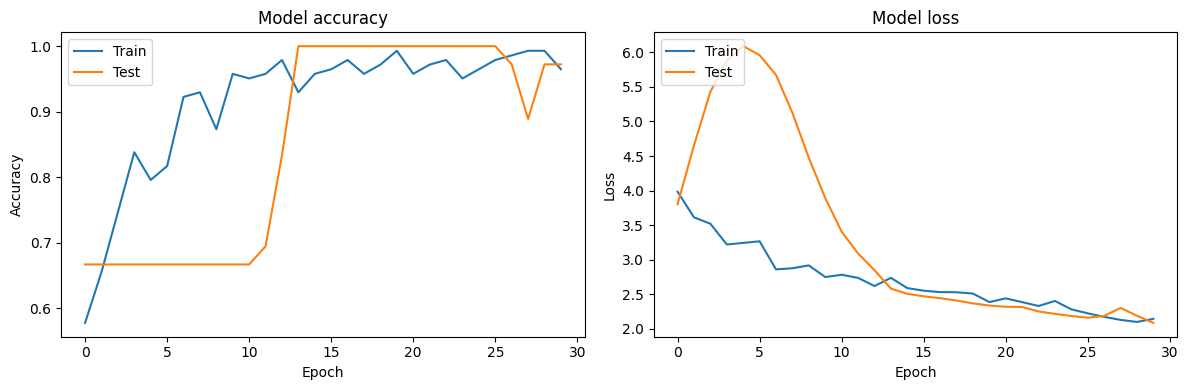

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show the plot
plt.tight_layout()



In [ ]:
def extract_features(audio_files):
    features = []
    for audio_file in audio_files:
        try:
            y, sr = librosa.load(audio_file)
            sr_per_window = int(sr * max_length)
            sr_hop = int(sr * window_hop)

            for i in range(0, len(y) - sr_per_window + 1, sr_hop):
                window = y[i:i+sr_per_window]
                mfccs = librosa.feature.mfcc(y=window, sr=sr)
                chroma_stft = librosa.feature.chroma_stft(y=window,sr=sr)
                spectral_contrast=librosa.feature.spectral_contrast(y=window,sr=sr)

                print(f"Length of MFCCs: {len(mfccs.mean(axis=1))}")
                print(f"Length of Chroma STFT: {len(chroma_stft.mean(axis=1))}")
                print(f"Length of Spectral Contrast: {len(spectral_contrast.mean(axis=1))}")

                window_features=np.concatenate((mfccs.mean(axis=1),chroma_stft.mean(axis=1),spectral_contrast.mean(axis=1)))

                features.append(window_features)

        except Exception as e:
            print(f"Error processing {audio_file}: {str(e)}")

    return np.array(features)

audio_file_path = '/content/drive/MyDrive/PBL/ai_voice/ainoise.mp3'
predicted_class = classify_audio_file(model, audio_file_path)

if predicted_class[0] == 0:
  print("The audio file is classified as AI voice.")
else:
  print("The audio file is classified as human voice.")


ValueError: ignored

In [ ]:
# 예측 및 결과 출력
test_audio_file = "/content/drive/MyDrive/PBL/ai_voice/ai/vocals_10sec.mp3"
test_features = extract_features(test_audio_file, max_length)
test_features = test_features.reshape(1, test_features.shape[0], 1)
prediction = model.predict(test_features)
predicted_class = np.argmax(prediction)  # 가장 높은 확률을 가진 클래스 선택

confidence = prediction[0][predicted_class] * 100  # 선택된 클래스의 확률

if predicted_class == 0:
    print(f"테스트 음성은 AI 음성입니다. (확신도: {confidence:.2f}%)")
else:
    print(f"테스트 음성은 인간 음성입니다. (확신도: {confidence:.2f}%)")


1/1 [==============================] - 0s 31ms/step
테스트 음성은 인간 음성입니다. (확신도: 65.73%)


추가적으로 필요한 코드

In [ ]:
# 앞부분 padding 추가

import os
from pydub import AudioSegment

# 입력 폴더 경로
input_folder = "/content/drive/MyDrive/PBL/ai_voice/ai/new50"

# 출력 폴더 경로
output_folder = "/content/drive/MyDrive/PBL/ai_voice/ai/new50_padding"

# 추가할 패딩의 길이 (밀리초 단위)
padding_duration = 1000  # 1초를 밀리초로 표시

# 입력 폴더의 모든 파일 목록 가져오기
input_files = os.listdir(input_folder)

# 입력 폴더의 각 파일에 대해 변환 작업 수행
for input_file_name in input_files:
    # 입력 파일의 전체 경로 생성
    input_file_path = os.path.join(input_folder, input_file_name)

    # 음성 파일을 로드합니다.
    audio = AudioSegment.from_file(input_file_path)

    # 패딩을 생성합니다.
    padding = AudioSegment.silent(duration=padding_duration)

    # 패딩을 음성 파일의 앞에 추가합니다.
    output_audio = padding + audio

    # 새로운 파일 이름 생성 (패딩을 추가한 파일이므로 "_padded"를 추가합니다)
    output_file_name = input_file_name.split('.')[0] + "_padded." + input_file_name.split('.')[1]

    # 결과 파일의 경로 생성 (출력 폴더에 저장)
    output_file_path = os.path.join(output_folder, output_file_name)

    # 결과를 MP3 파일로 저장합니다.
    output_audio.export(output_file_path, format="mp3")

    print(f"{input_file_name}에 1초 패딩 추가 및 저장 완료.")

print("모든 파일 변환이 완료되었습니다.")

4.mp3에 1초 패딩 추가 및 저장 완료.
30.mp3에 1초 패딩 추가 및 저장 완료.
7.mp3에 1초 패딩 추가 및 저장 완료.
39.mp3에 1초 패딩 추가 및 저장 완료.
16.mp3에 1초 패딩 추가 및 저장 완료.
33.mp3에 1초 패딩 추가 및 저장 완료.
37.mp3에 1초 패딩 추가 및 저장 완료.
46.mp3에 1초 패딩 추가 및 저장 완료.
8.mp3에 1초 패딩 추가 및 저장 완료.
44.mp3에 1초 패딩 추가 및 저장 완료.
36.mp3에 1초 패딩 추가 및 저장 완료.
22.mp3에 1초 패딩 추가 및 저장 완료.
50.mp3에 1초 패딩 추가 및 저장 완료.
5.mp3에 1초 패딩 추가 및 저장 완료.
31.mp3에 1초 패딩 추가 및 저장 완료.
43.mp3에 1초 패딩 추가 및 저장 완료.
6.mp3에 1초 패딩 추가 및 저장 완료.
38.mp3에 1초 패딩 추가 및 저장 완료.
34.mp3에 1초 패딩 추가 및 저장 완료.
32.mp3에 1초 패딩 추가 및 저장 완료.
3.mp3에 1초 패딩 추가 및 저장 완료.
25.mp3에 1초 패딩 추가 및 저장 완료.
18.mp3에 1초 패딩 추가 및 저장 완료.
40.mp3에 1초 패딩 추가 및 저장 완료.
26.mp3에 1초 패딩 추가 및 저장 완료.
2.mp3에 1초 패딩 추가 및 저장 완료.
21.mp3에 1초 패딩 추가 및 저장 완료.
11.mp3에 1초 패딩 추가 및 저장 완료.
15.mp3에 1초 패딩 추가 및 저장 완료.
12.mp3에 1초 패딩 추가 및 저장 완료.
49.mp3에 1초 패딩 추가 및 저장 완료.
23.mp3에 1초 패딩 추가 및 저장 완료.
17.mp3에 1초 패딩 추가 및 저장 완료.
19.mp3에 1초 패딩 추가 및 저장 완료.
42.mp3에 1초 패딩 추가 및 저장 완료.
35.mp3에 1초 패딩 추가 및 저장 완료.
45.mp3에 1초 패딩 추가 및 저장 완료.
13.mp3에 1초 패딩 추가 및 저장 완료.
48.mp3에 1초 패딩 추가 및 